In [ ]:
!pip install -q -U tensorflow-text
!pip install torchvision 
!pip install -q tf-models-official
!pip install transformers
!pip install emoji

     |████████████████████████████████| 4.6 MB 37.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 438 kB 57.8 MB/s 
     |████████████████████████████████| 1.6 MB 68.3 MB/s 
     |████████████████████████████████| 5.8 MB 49.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 38.1 MB/s 
     |████████████████████████████████| 48.3 MB 1.5 MB/s 
     |████████████████████████████████| 92 kB 13.1 MB/s 
     |████████████████████████████████| 352 kB 69.8 MB/s 
     |████████████████████████████████| 99 kB 10.2 MB/s 
     |████████████████████████████████| 636 kB 52.0 MB/s 
     |████████████████████████████████| 1.2 MB 49.6 MB/s 
     |████████████████████████████████| 237 kB 75.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.5 MB/s 
Looking in indexes: https://pypi.o

In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

tf.get_logger().setLevel('ERROR')
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification,BertForSequenceClassification, BertTokenizer,  AdamW
from seqeval.metrics import classification_report
import pickle

import nltk
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import cuda
device = 'cuda:0' if cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
import emoji
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub("", text)

In [ ]:
path = '/content/drive/MyDrive/catalan_training_dataset_labels (1).xlsx'

In [ ]:
file = pd.read_excel(path)

In [ ]:
file.head()

,username,creation_date,tweet,likes,retweets,crime_label,crime_type
0,mossos,2015-03-17 17:33:05,Taxa fets x mil habitants a la RP Central (32'...,1.0,1.0,Not Crime,NaN
1,mossos,2020-01-07 07:22:57,"Comencen les rebaixes d’hivern, fes les compre...",38.0,7.0,Not Crime,NaN
2,mossos,2018-02-24 12:19:29,Amb @gremihotelsbcn i @RestauracioBCN hem lliu...,54.0,27.0,Not Crime,NaN
3,mossos,2017-06-14 09:02:20,Robaven en empreses i bars de les comarques ta...,9.0,1.0,Crime,Theft
4,mossos,2017-08-06 09:12:13,Si viatges amb cotxe 🚗 i un altre usuari t'ind...,44.0,47.0,Not Crime,NaN


In [ ]:
file = file.loc[file['crime_label'] == 'Crime']

In [ ]:
file = file.reset_index(drop=True)

In [ ]:
len(file)

1120

Text(0.5, 1.0, 'Training dataset')

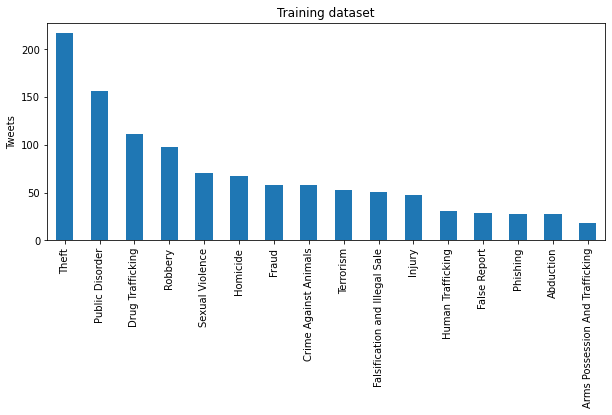

In [ ]:
plt.figure(figsize=(10,4))
file.crime_type.value_counts().plot(kind='bar')
plt.ylabel('Tweets')
plt.title('Training dataset')

In [ ]:
file.crime_type.unique()

array(['Theft', 'Public Disorder', 'Robbery', 'Drug Trafficking',
       'Falsification and Illegal Sale', 'Homicide', 'Injury',
       'Sexual Violence', 'Fraud', 'Phishing', 'Crime Against Animals',
       'Terrorism', 'Abduction', 'Arms Possession And Trafficking',
       'Human Trafficking', 'False Report'], dtype=object)

In [ ]:
len(file.crime_type.unique())

16

In [ ]:
file.loc[file['crime_type'].isnull()]

,username,creation_date,tweet,likes,retweets,crime_label,crime_type


In [ ]:
from collections import Counter
Counter(file.crime_type)

Counter({'Abduction': 40,
         'Arms Possession And Trafficking': 35,
         'Crime Against Animals': 33,
         'Drug Trafficking': 174,
         'Escape': 36,
         'False Report': 18,
         'Falsification and Illegal Sale': 52,
         'Fraud': 70,
         'Homicide': 54,
         'Human Trafficking': 35,
         'Injury': 49,
         'Phishing': 58,
         'Public Disorder': 38,
         'Robbery': 34,
         'Sexual Violence': 71,
         'Terrorism': 32,
         'Theft': 55})

In [ ]:
all_tags = sorted(set(file.crime_type.unique()))
num_tags = len(all_tags)
print("Number of tags:", num_tags)
print("Tags:", all_tags)

Number of tags: 17
Tags: ['Abduction', 'Arms Possession And Trafficking', 'Crime Against Animals', 'Drug Trafficking', 'Escape', 'False Report', 'Falsification and Illegal Sale', 'Fraud', 'Homicide', 'Human Trafficking', 'Injury', 'Phishing', 'Public Disorder', 'Robbery', 'Sexual Violence', 'Terrorism', 'Theft']


In [ ]:
tag2index = {tag: i for i, tag in enumerate(all_tags)}
index2tag = {i: tag for tag, i in tag2index.items()}

In [ ]:
file['crime_type_category'] = 0
for i in range(len(file)): 
   file['crime_type_category'][i] = tag2index[file['crime_type'][i]]

In [ ]:
file = file.sample(frac=1).reset_index(drop=True)

In [ ]:
X = [tweet for tweet in file.tweet_ca]
y = [ label for label in file.crime_type_category]

# splitting data from training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

print("X[0]:", X[0])
print("y[0]:", y[0])

print("Size X_train: ", len(X_train))
print("Size X_valid: ", len(X_valid))
print("Size X_test: ", len(X_test))

X[0]: El cultiu desmuntat amb 22 plantes de marihuana a la 1 instal·lació municipal de Granada i detinguts els seus 2 "jardiners" http://t.co/qtwpolsxhy
y[0]: 3
Size X_train:  707
Size X_valid:  88
Size X_test:  89


In [ ]:
from collections import Counter
Counter(y_train)

Counter({0: 33,
         1: 23,
         2: 23,
         3: 135,
         4: 33,
         5: 16,
         6: 42,
         7: 57,
         8: 45,
         9: 32,
         10: 36,
         11: 45,
         12: 29,
         13: 28,
         14: 55,
         15: 25,
         16: 50})

In [ ]:
model_name = "PlanTL-GOB-ES/roberta-base-ca"
max_length = 512

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
class dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
        self.len = len(X)
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __len__(self):
        return self.len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        text = self.X[index]
        label = self.y[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(text,
                             padding='max_length', max_length = self.max_len, 
                              truncation=True, return_tensors="pt")
        
        encoding['label'] = torch.tensor(label)
        return encoding

In [ ]:
max_seq_len = 128
training_set = dataset(X_train, y_train, tokenizer, max_seq_len)
validation_set = dataset(X_valid, y_valid, tokenizer, max_seq_len)
testing_set = dataset(X_test, y_test, tokenizer, max_seq_len)

In [ ]:
training_set[0]

{'input_ids': tensor([[    0,   387,   288, 16197,  3149,  1116,  7360,   264,  2476,   486,
           397,    24,  5057,    12,   295,   264,   280,  4851,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

In [ ]:
max_seq_len = max([len(x) for x in X])
print("max_seq_leng:", max_seq_len)

max_seq_leng: 323


In [ ]:
training_set[0]["label"]

tensor(14)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(tag2index),ignore_mismatched_sizes=True)
model = model.to(device)

Downloading:   0%|          | 0.00/481M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-ca were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.out_proj.weight', 'classifi

In [ ]:
TRAIN_BATCH_SIZE = 40
VALID_BATCH_SIZE = 40
EPOCHS = 20
LEARNING_RATE = 1e-05

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
inputs = { key: training_set[1][key] for key in ['input_ids','attention_mask','label'] }
ids = inputs['input_ids'].to(device)
mask = inputs['attention_mask'].to(device)

labels =inputs['label'].to(device)
outputs = model(input_ids=ids,attention_mask=mask,labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(2.7719, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits

tensor([[-0.0145,  0.0625, -0.1533,  0.1224,  0.0937, -0.1115, -0.1118,  0.0232,
         -0.2438, -0.0694,  0.2668, -0.1687, -0.2273, -0.0985, -0.0906,  0.0299,
          0.0109]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8 )

In [ ]:
from pandas._libs.index import BaseMultiIndexCodesEngine
def valid(model, data_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):

            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # if idx % 100==0:
            #     loss_step = eval_loss/nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # print(f"Validation : loss {eval_loss:.2f} accuracy {eval_accuracy:.2f}")

    return labels, predictions, eval_loss, eval_accuracy

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    with tqdm(training_loader, 'batch') as tepoch:
        for idx, batch in enumerate(tepoch):
            tepoch.set_description(f'Epoch {epoch}')
            
            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)  

            loss, tr_logits = outputs[0], outputs[1]
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)
            
            # if idx % 100==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     print(f"Training loss per 100 training steps: {loss_step:.2f}")
            
            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
          
    
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
            
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tr_labels.extend(labels)
            tr_preds.extend(predictions)

            tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            tr_accuracy += tmp_tr_accuracy
        
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=10)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=tr_loss / nb_tr_steps, accuracy=tr_accuracy / nb_tr_steps)
    
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
              
    _, _ , val_loss, val_acc = valid(model, validation_loader)
    
    return epoch_loss, tr_accuracy, val_loss, val_acc

In [ ]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[], 'epoch':[]}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['epoch'].append(epoch+1)

Epoch 19: 100%|██████████| 23/23 [00:18<00:00,  1.25it/s, accuracy=1, loss=0.0532]


<function matplotlib.pyplot.show>

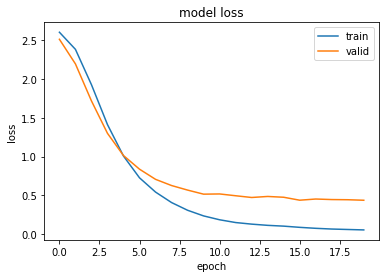

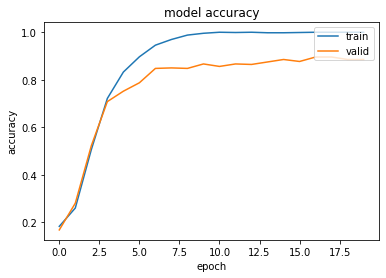

In [ ]:
plt.figure(1)
plt.plot(history[f'train_loss'])
plt.plot(history[f'val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

plt.figure(2)
plt.plot(history[f'train_accuracy'])
plt.plot(history[f'val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

In [ ]:
from sklearn.metrics import classification_report

labels, predictions, loss, accuracy = valid(model, testing_loader)
print(f"Validation : loss {loss:.2f} accuracy {accuracy:.2f}")
print(classification_report(labels, predictions))

Validation : loss 0.27 accuracy 0.93
                                precision    recall  f1-score   support

                     Abduction       1.00      1.00      1.00         6
         Crime Against Animals       1.00      1.00      1.00         5
              Drug Trafficking       0.89      1.00      0.94         8
                  False Report       1.00      1.00      1.00         2
Falsification and Illegal Sale       1.00      0.80      0.89         5
                         Fraud       0.91      1.00      0.95        10
                      Homicide       1.00      0.78      0.88         9
             Human Trafficking       0.75      1.00      0.86         6
                        Injury       0.71      0.83      0.77         6
                      Phishing       1.00      1.00      1.00         2
               Public Disorder       1.00      0.89      0.94        19
                       Robbery       0.88      0.88      0.88         8
               Sexual Viol

In [ ]:
not_classified = []
for i in range(len(labels)): 
  if labels[i] != predictions[i]:
    not_classified.append(i)
  

In [ ]:
len(not_classified)

8

In [ ]:
def inference(sentence, tokenizer):
    inputs = tokenizer(sentence,padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    
    token_predictions = [index2tag[i] for i in flattened_predictions.cpu().numpy()]

    return token_predictions

In [ ]:
for i in range(len(not_classified)):
  sentence = X_test[not_classified[i]]
  print('Tweet:', sentence)
  print('Label:', index2tag[y_test[not_classified[i]]])
  entities = inference(sentence,tokenizer)
  print('Prediction:',entities)
  print('################')

Tweet: A Masdenverge (el Montsià) un treballador pateix un accident laboral i el tanquen en un magatzem per amagar la seva situació irregular. En detenim el responsable per detenció il·legal, amenaces i coaccions https://t.co/1c7rOgxVG5
Label: Public Disorder
Prediction: ['Human Trafficking']
################
Tweet: A presó un home per calar foc a un pis a Amposta amb el seu fill de 14 mesos  i la seva exparella a l’interior
https://t.co/bNscap5i8d https://t.co/k2QAZy3oS7
Label: Homicide
Prediction: ['Robbery']
################
Tweet: La dona va quedar astorada en reconèixer a l'agressor.Era un company de feina #Cabanes #AltEmpordà #Mossos http://t.co/lvoEB0qJ65
Label: Homicide
Prediction: ['Injury']
################
Tweet: Desmantellem a BCN 1 magatzem de distribució il·legal de material destinat al top manta https://t.co/iYNy4SxjOX https://t.co/DRqXdOBg5I
Label: Falsification and Illegal Sale
Prediction: ['Drug Trafficking']
################
Tweet: Detinguts van participar en actes v

# Nueva sección

In [ ]:
directory = Path("/content/drive/MyDrive/Crime Type 93")
directory.mkdir(parents=True, exist_ok=True)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(str(directory))
# save the model weights and its configuration file
model.save_pretrained(directory)

parameters = (max_seq_len, all_tags, tag2index, index2tag)
pickle.dump(parameters, (directory / 'parrameters.pk').open('wb'))

print('All files saved')

All files saved
